In [1]:
# # Libraries
import pandas as pd
import numpy as np
import fasttext
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.fasttext import FastText
from gensim.models.fasttext import load_facebook_model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Bidirectional, LSTM, Dense, Embedding, Dropout, GlobalMaxPool1D, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from PIL import Image
from tensorflow.keras.optimizers import Adam
import re
from gensim.models.fasttext import load_facebook_vectors
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import fasttext.util
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from nltk.corpus import wordnet
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2

In [2]:
# Load train data
train_df = pd.read_csv('olid-training-v1.0.tsv',sep='\t')

# Select only tweet and subtask_a columns
train_df = train_df[["id", "tweet", "subtask_b"]]

# Load test data
test_df = pd.read_csv('testset-levelb.tsv',sep='\t')

# Select only tweet column
# test_df = test_df[["tweet"]]

# Define column names
column_names = ['id', 'label']

# Load labels
labels_df = pd.read_csv("labels-levelb.csv", header=None, names=column_names)

# Merge labels with test data
test_df = test_df.merge(labels_df, on="id")


In [3]:
train_df

,id,tweet,subtask_b
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,16820,Amazon is investigating Chinese employees who ...,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NaN
...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,TIN
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NaN
13237,82921,@USER And why report this garbage. We don't g...,TIN
13238,27429,@USER Pussy,UNT


In [4]:
test_df
test_df

,id,tweet,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,TIN
1,60133,#NoPasaran: Unity demo to oppose the far-right...,TIN
2,83681,. . . What the fuck did he do this time?,TIN
3,65507,@USER Do you get the feeling he is kissing @US...,TIN
4,12588,@USER Nigga ware da hits at,UNT
...,...,...,...
235,22569,"#Antifa are mentally unstable cowards, pretend...",TIN
236,48938,@USER @USER And Browning looked like dog shit ...,TIN
237,41438,All two of them taste like ass. URL,TIN
238,73439,#DespicableDems lie again about rifles. Dem Di...,TIN


2. Data Preprocessing:

In [5]:
train_df['text'] = train_df['tweet']
train_df['sentiment'] = train_df['subtask_b']
train_df.head()
train_df = train_df[['sentiment', 'text']]

test_df['text'] = test_df['tweet']
test_df['sentiment'] = test_df['label']
test_df.head()
test_df = test_df[['sentiment', 'text']]


In [6]:
# Drop rows with NULL labels in train_df['sentiment']
train_df.dropna(subset=['sentiment'], inplace=True)

train_df


C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\2189161098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(subset=['sentiment'], inplace=True)


,sentiment,text
0,UNT,@USER She should ask a few native Americans wh...
1,TIN,@USER @USER Go home you’re drunk!!! @USER #MAG...
3,UNT,"@USER Someone should'veTaken"" this piece of sh..."
5,TIN,@USER Liberals are all Kookoo !!!
6,UNT,@USER @USER Oh noes! Tough shit.
...,...,...
13223,TIN,@USER is advocating for conduct within bounds ...
13227,TIN,@USER @USER @USER @USER Liars like the Antifa ...
13235,TIN,@USER Sometimes I get strong vibes from people...
13237,TIN,@USER And why report this garbage. We don't g...


In [7]:
test_df

,sentiment,text
0,TIN,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,TIN,#NoPasaran: Unity demo to oppose the far-right...
2,TIN,. . . What the fuck did he do this time?
3,TIN,@USER Do you get the feeling he is kissing @US...
4,UNT,@USER Nigga ware da hits at
...,...,...
235,TIN,"#Antifa are mentally unstable cowards, pretend..."
236,TIN,@USER @USER And Browning looked like dog shit ...
237,TIN,All two of them taste like ass. URL
238,TIN,#DespicableDems lie again about rifles. Dem Di...


In [8]:
# Clean text
def clean_text(text):
  text = "".join(c for c in text if c not in string.punctuation)
  tokens = re.split('\W+', text)
  text = [word for word in tokens if word not in stop_words]
  return text

def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

def remove_html(text):
  html = re.compile(r"<.*?>")
  return html.sub(r"", text)

def remove_emoji(string):
  emoji_pattern = re.compile(
      "["
      u"\U0001F600-\U0001F64F"  #emoticon
      u"\U0001F300-\U0001F5FF"  #symbols & pictographs
      u"\U0001F680-\U0001F6FF"  #transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  #flags (ios)
      "]+",
      flags=re.UNICODE,
      )
  return emoji_pattern.sub(r"", string)

def remove_punct(text):
  table = str.maketrans("","", string.punctuation)
  return text.translate(table)

def remove_word(string):
  text = re.compile('rt')
  return text.sub(r"", string)

train_df['text'] = train_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
train_df['text'] = train_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
train_df['text'] = train_df.text.map(lambda x: remove_url(x))
train_df['text'] = train_df.text.map(lambda x: remove_html(x))
train_df['text'] = train_df.text.map(lambda x: remove_emoji(x))
train_df['text'] = train_df.text.map(lambda x: remove_punct(x))
train_df['text'] = train_df.text.map(lambda x: remove_word(x))
train_df['text'] = train_df['text'].str.replace('url', '')
train_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\1325535545.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\1325535545.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(lambda x: x.lower())
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\1325535545.py:38: SettingWithCopyWarning: 
A value is trying to be set on a co

,sentiment,text
0,UNT,she should ask a few native americans what th...
1,TIN,go home youre drunk maga trump2020
3,UNT,someone shouldvetaken this piece of shit to a...
5,TIN,liberals are all kookoo
6,UNT,oh noes tough shit


In [9]:
test_df['text'] = test_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
test_df['text'] = test_df['text'].apply(lambda x: x.lower())
test_df['text'] = test_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_df['text'] = test_df.text.map(lambda x: remove_url(x))
test_df['text'] = test_df.text.map(lambda x: remove_html(x))
test_df['text'] = test_df.text.map(lambda x: remove_emoji(x))
test_df['text'] = test_df.text.map(lambda x: remove_punct(x))
test_df['text'] = test_df.text.map(lambda x: remove_word(x))
test_df['text'] = test_df['text'].str.replace('url', '')
test_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\3808688845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\3808688845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply(lambda x: x.lower())
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\3808688845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,sentiment,text
0,TIN,whoisq wherestheserver dumpnike declasfisa dem...
1,TIN,nopasaran unity demo to oppose the farright in...
2,TIN,what the fuck did he do this time
3,TIN,do you get the feeling he is kissing behind ...
4,UNT,nigga ware da hits at


In [10]:
# # Lowercasing
# df['text'] = df['text'].str.lower()
# df.head()

In [11]:
# Tokenization
train_df['text'] = train_df['text'].apply(word_tokenize)
train_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\895518308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(word_tokenize)


,sentiment,text
0,UNT,"[she, should, ask, a, few, native, americans, ..."
1,TIN,"[go, home, youre, drunk, maga, trump2020]"
3,UNT,"[someone, shouldvetaken, this, piece, of, shit..."
5,TIN,"[liberals, are, all, kookoo]"
6,UNT,"[oh, noes, tough, shit]"


In [12]:
# Tokenization
test_df['text'] = test_df['text'].apply(word_tokenize)
test_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\1630069719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply(word_tokenize)


,sentiment,text
0,TIN,"[whoisq, wherestheserver, dumpnike, declasfisa..."
1,TIN,"[nopasaran, unity, demo, to, oppose, the, farr..."
2,TIN,"[what, the, fuck, did, he, do, this, time]"
3,TIN,"[do, you, get, the, feeling, he, is, kissing, ..."
4,UNT,"[nigga, ware, da, hits, at]"


In [13]:
# # Stop word removal
# stop_words = set(stopwords.words('english'))
# train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
# train_df.head()

In [14]:
# # Stop word removal
# stop_words = set(stopwords.words('english'))
# test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
# test_df.head()

In [15]:
# # Lemmatization
# lemmatizer = WordNetLemmatizer()
# df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# df.head()

In [16]:
# import random

# def synonym_replacement(text, n):
#     new_text = text.copy()
#     random_word_list = list(set([word for word in text if word not in stop_words]))
#     random.shuffle(random_word_list)
#     num_replaced = 0
    
#     for random_word in random_word_list:
#         synonyms = get_synonyms(random_word)
#         if len(synonyms) >= 1:
#             synonym = random.choice(synonyms)
#             new_text = [synonym if word == random_word else word for word in new_text]
#             num_replaced += 1
        
#         if num_replaced >= n:  # Only replace up to n words
#             break

#     sentence = ' '.join(new_text)
#     new_words = sentence.split(' ')

#     return new_words

# def get_synonyms(word):
#     synonyms = set()
#     for syn in wordnet.synsets(word):
#         for lemma in syn.lemmas():
#             synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
#             synonym = "".join([char for char in synonym if char in ' abcdefghijklmnopqrstuvwxyz'])
#             synonyms.add(synonym)
#     if word in synonyms:
#         synonyms.remove(word)
#     return list(synonyms)


In [17]:
# df = df_augmented
# df.head()

In [18]:
# df['text'] = df['text_augmented']
# df = df[['sentiment', 'text']]
# df.head()

In [19]:
# train_data = df
# train_data.head()

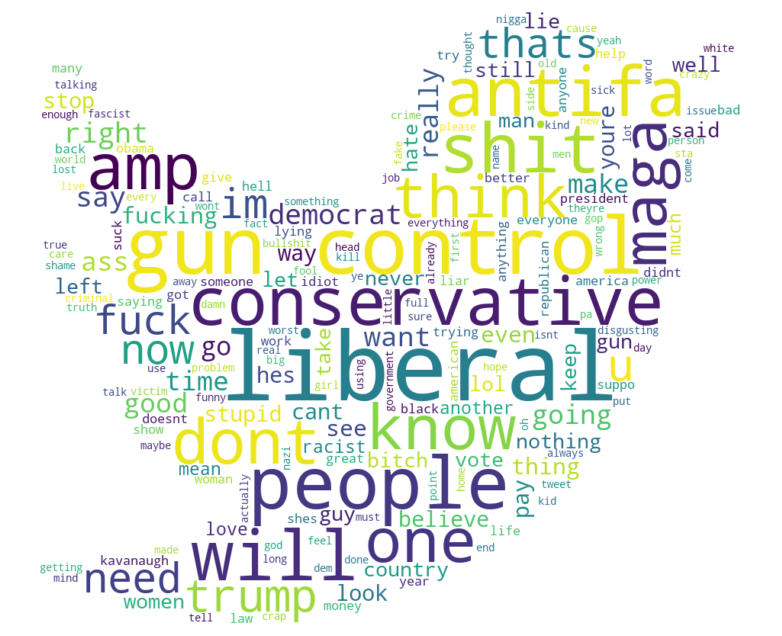

In [20]:
# Visualization Word Cloud
text = ' '.join([' '.join(tweet) for tweet in train_df['text']])
twitter_mask = np.array(Image.open("twitter_mask.png"))
wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

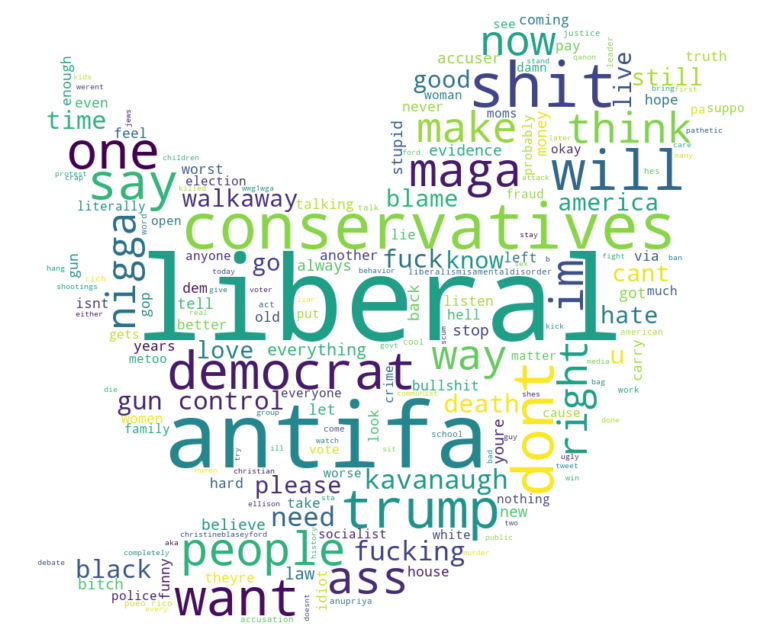

In [21]:
# Visualization Word Cloud
text = ' '.join([' '.join(tweet) for tweet in test_df['text']])
twitter_mask = np.array(Image.open("twitter_mask.png"))
wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Test_data

In [22]:
# # TEST DATA
# import pandas as pd

# # Membaca data dari file testset-levela.tsv
# tweet = pd.read_csv('testset-levela.tsv', sep='\t')

# # Membaca label dari file labels-levela.csv
# labels = pd.read_csv('labels-levela.csv', header=None, names=['id', 'label'])

# # Menggabungkan data uji dengan label berdasarkan kolom 'id'
# test_data = pd.merge(tweet, labels, on='id')

# # Menampilkan DataFrame hasil
# print(test_data.head())


In [23]:
# labels

In [24]:
# test_data['text'] = test_data['tweet']
# test_data['sentiment'] = test_data['label']
# test_data.head()
# # Drop unnecessary columns
# test_data = test_data[['sentiment', 'text']]
# test_data

In [25]:
# test_data['text'] = test_data['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
# test_data['text'] = test_data['text'].apply(lambda x: x.lower())
# test_data['text'] = test_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
# test_data['text'] = test_data.text.map(lambda x: remove_url(x))
# test_data['text'] = test_data.text.map(lambda x: remove_html(x))
# test_data['text'] = test_data.text.map(lambda x: remove_emoji(x))
# test_data['text'] = test_data.text.map(lambda x: remove_punct(x))
# test_data['text'] = test_data.text.map(lambda x: remove_word(x))
# test_data.head()

In [26]:
# # Lowercasing
# test_data['text'] = test_data['text'].str.lower()
# test_data.head()

In [27]:
# # Tokenization
# test_data['text'] = test_data['text'].apply(word_tokenize)
# test_data.head()

In [28]:
# # Visualization Word Cloud
# text = ' '.join([' '.join(tweet) for tweet in test_data['text']])
# twitter_mask = np.array(Image.open("twitter_mask.png"))
# wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(text)

# plt.figure(figsize=(10,8))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

EMBEDDING

In [29]:
# Load pre-trained FastText model
fasttext_model = FastText.load_fasttext_format('cc.en.300.bin')
# fasttext_model = fasttext.load_model('cc.en.300.bin')

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\2865677329.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format('cc.en.300.bin')


In [30]:
import numpy as np
from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
def create_text_embeddings(df, fasttext_model, tfidf_vectorizer):
    # Fit the TF-IDF vectorizer on the training data
    if not tfidf_vectorizer.get_params()['input'] == 'content':
        # Assuming 'content' input is used, change it if needed
        tfidf_vectorizer.set_params(input='content')

    flat_list_of_tokens = [' '.join(text) for text in df['text']]
    tfidf_result = tfidf_vectorizer.fit_transform(flat_list_of_tokens).toarray()

    # Create a dictionary to hold TF-IDF weighted vectors
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_vectors = {}
    for word in tfidf_feature_names:
        if word in fasttext_model.wv.key_to_index:
            word_tfidf_weight = tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[word]]
            word_vector = fasttext_model.wv[word]
            tfidf_vectors[word] = word_vector * word_tfidf_weight

    # Function to blend the FastText and TF-IDF vectors for a document
    def blend_vectors(row):
        vectors = [tfidf_vectors.get(word, np.zeros(fasttext_model.vector_size)) for word in row['text']]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(fasttext_model.vector_size)

    # Apply the blending function to each row
    df['text_embeddings'] = df.apply(blend_vectors, axis=1)

    return df

# Usage
train_df = create_text_embeddings(train_df, fasttext_model, tfidf_vectorizer)
test_df = create_text_embeddings(test_df, fasttext_model, tfidf_vectorizer)

# Visualize the embedding
print(train_df[['text_embeddings']].head())
print(test_df[['text_embeddings']].head())


C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\2225866856.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_embeddings'] = df.apply(blend_vectors, axis=1)
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\2225866856.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_embeddings'] = df.apply(blend_vectors, axis=1)


                                     text_embeddings
0  [-0.06317513063549995, 0.19027165674532837, 0....
1  [0.09855657443404198, -0.006447875251372655, -...
3  [0.04226796827667082, -0.0609424544705285, 0.1...
5  [0.09699665, 0.104931824, -0.17258003, 0.35816...
6  [0.47497192, -1.1416787, -0.098030716, 0.06559...
                                     text_embeddings
0  [-0.12403261471539735, -0.03708191256970167, 0...
1  [-0.07211361097038857, -0.14790458445038115, 0...
2  [0.10697416, 0.006545134, 0.12003656, 0.223879...
3  [0.09498026, -0.0950447, 0.14048852, 0.1188831...
4  [0.48868075, 0.20909193, -0.16319175, 0.454911...


In [31]:
# Binary encoding of sentiment
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: 1 if x == 'TIN' else 0)
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: 1 if x == 'TIN' else 0)

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\1632144479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sentiment'] = train_df['sentiment'].apply(lambda x: 1 if x == 'TIN' else 0)
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_28552\1632144479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sentiment'] = test_df['sentiment'].apply(lambda x: 1 if x == 'TIN' else 0)


In [32]:
train_df

,sentiment,text,text_embeddings
0,0,"[she, should, ask, a, few, native, americans, ...","[-0.06317513063549995, 0.19027165674532837, 0...."
1,1,"[go, home, youre, drunk, maga, trump2020]","[0.09855657443404198, -0.006447875251372655, -..."
3,0,"[someone, shouldvetaken, this, piece, of, shit...","[0.04226796827667082, -0.0609424544705285, 0.1..."
5,1,"[liberals, are, all, kookoo]","[0.09699665, 0.104931824, -0.17258003, 0.35816..."
6,0,"[oh, noes, tough, shit]","[0.47497192, -1.1416787, -0.098030716, 0.06559..."
...,...,...,...
13223,1,"[is, advocating, for, conduct, within, bounds,...","[0.036604474221467564, -0.03973908303305507, 0..."
13227,1,"[liars, like, the, antifa, twins, you, vigorou...","[-0.06281219, -0.039050307, -0.021062229, 0.26..."
13235,1,"[sometimes, i, get, strong, vibes, from, peopl...","[0.05197699648915264, -0.1675829669541639, -0...."
13237,1,"[and, why, repo, this, garbage, we, dont, give...","[-0.22884110882878303, 0.04711707897949964, 0...."


In [33]:
test_df

,sentiment,text,text_embeddings
0,1,"[whoisq, wherestheserver, dumpnike, declasfisa...","[-0.12403261471539735, -0.03708191256970167, 0..."
1,1,"[nopasaran, unity, demo, to, oppose, the, farr...","[-0.07211361097038857, -0.14790458445038115, 0..."
2,1,"[what, the, fuck, did, he, do, this, time]","[0.10697416, 0.006545134, 0.12003656, 0.223879..."
3,1,"[do, you, get, the, feeling, he, is, kissing, ...","[0.09498026, -0.0950447, 0.14048852, 0.1188831..."
4,0,"[nigga, ware, da, hits, at]","[0.48868075, 0.20909193, -0.16319175, 0.454911..."
...,...,...,...
235,1,"[antifa, are, mentally, unstable, cowards, pre...","[-0.09385699, -0.24292523, -0.08520986, 0.3494..."
236,1,"[and, browning, looked, like, dog, shit, again...","[0.07576641, 0.01057557, 0.0959928, 0.4227875,..."
237,1,"[all, two, of, them, taste, like, ass]","[0.055144273, -0.087637976, 0.2429545, 0.19231..."
238,1,"[despicabledems, lie, again, about, rifles, de...","[-0.12543696673674276, 0.12468396039912477, 0...."


4. LSTM

In [34]:
# Load train_df and test_df
# (Assuming you have already loaded train_df and test_df)

# Convert embeddings and labels to numpy format for train_df
X_train = np.array(train_df['text_embeddings'].tolist())
y_train = train_df['sentiment'].values

# Reshape train data for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Split train data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert embeddings and labels to numpy format for test_df
X_test = np.array(test_df['text_embeddings'].tolist())

filtered_test_df = test_df[test_df['sentiment'].isin(y_train)]

# Extract labels for test data
y_test = filtered_test_df['sentiment'].values

# Reshape test data for LSTM
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Reshape y_train for compatibility with LSTM output
y_train = y_train.reshape(y_train.shape[0], 1)


In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

model = Sequential()
# model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(196, return_sequences=True, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(196, return_sequences=True)))
# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(max_length, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(max_length, activation = "relu"))
model.add(Dropout(0.5))
# model.add(Dense(64, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Swish())  # Gunakan layer Swish di sini
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Build the model
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 1, 392)            779296    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 1, 392)            0         
                                                                 
 dense_12 (Dense)            (None, 1, 40)             15720     
                                                                 
 dropout_13 (Dropout)        (None, 1, 40)             0         
                                                                 
 dense_13 (Dense)            (None, 1, 20)             820       
                                                                 
 dropout_14 (Dropout)        (None, 1, 20)             0         
                                                      

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
110/110 [==============================] - 6s 20ms/step - loss: 0.4271 - accuracy: 0.8710 - val_loss: 0.3603 - val_accuracy: 0.8727
Epoch 2/50
110/110 [==============================] - 2s 14ms/step - loss: 0.3700 - accuracy: 0.8832 - val_loss: 0.3490 - val_accuracy: 0.8727
Epoch 3/50
110/110 [==============================] - 1s 13ms/step - loss: 0.3507 - accuracy: 0.8847 - val_loss: 0.3447 - val_accuracy: 0.8761
Epoch 4/50
110/110 [==============================] - 1s 13ms/step - loss: 0.3387 - accuracy: 0.8852 - val_loss: 0.3425 - val_accuracy: 0.8739
Epoch 5/50
110/110 [==============================] - 1s 13ms/step - loss: 0.3339 - accuracy: 0.8838 - val_loss: 0.3446 - val_accuracy: 0.8727
Epoch 6/50
110/110 [==============================] - 1s 13ms/step - loss: 0.3258 - accuracy: 0.8855 - val_loss: 0.3438 - val_accuracy: 0.8739
Epoch 7/50
110/110 [==============================] - 1s 13ms/step - loss: 0.3211 - accuracy: 0.8886 - val_loss: 0.3438 - val_accuracy: 0.8761

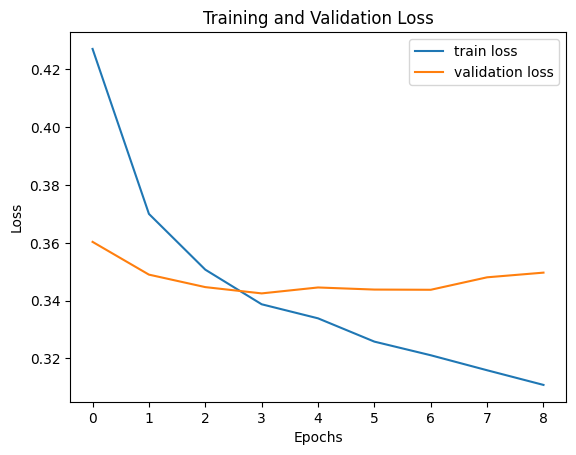

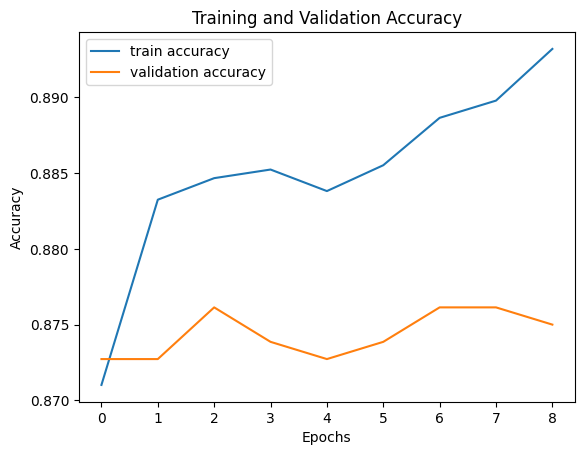

In [58]:
# Graph Result
# Plotting the training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# Result
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

8/8 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.67      0.07      0.13        27
           1       0.89      1.00      0.94       213

    accuracy                           0.89       240
   macro avg       0.78      0.53      0.54       240
weighted avg       0.87      0.89      0.85       240

Accuracy: 0.8916666666666667
